# 2018-05-09 - CHAMP output binaire
Pour valider la robustesse de l'apprentissage du layer 1 :

On importe les MC et on les filtre :

Size= torch.Size([1, 400, 1, 64, 64])
Gaussian filtered


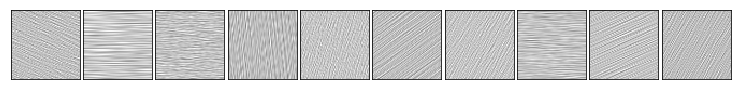

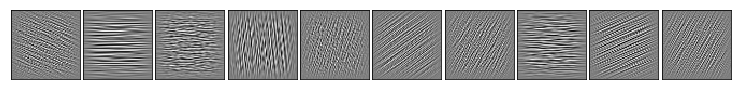

In [1]:
%matplotlib inline
import CHAMP.MC as MotionClouds
from CHAMP.DataLoader import LoadData, LoadCloudsDB
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData
from CHAMP.Monitor import DisplayDico
import os

path = './16_clouds_easy'

TrSet, TeSet = LoadData(name = 'Clouds', data_path =path, decorrelate=False, resize=None, download = False,
                       clouds_diff = 'easy')
to_display = TrSet[0][0, 0:10, :, :, :] #displays 10 clouds

print('Size=', TrSet[0].shape)
DisplayDico(to_display)

Normalized_TrSet, _, _, _ = LocalContrastNormalization(TrSet)
to_display = Normalized_TrSet[0][0, 0:10, :, :, :]

Filtered_L_TrSet = FilterInputData(
    Normalized_TrSet, sigma=0.25, style='Custom', start_R=15)
to_display = Filtered_L_TrSet[0][0, 0:10, :, :, :]
print("Gaussian filtered")
DisplayDico(to_display)

Premier layer convo : On entraine le réseau (4 mn/200 epochs sur une 1080) :

In [2]:
from CHAMP.CHAMP_Layer import CHAMP_Layer
from CHAMP.DataLoader import LoadData
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData, GenerateMask
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayWhere

# MP Parameters
nb_dico = 16
width = 10
dico_size = (width, width)
l0 = 20
seed = 30
# Learning Parameters
eta = .05
nb_epoch = 200

#expect approx 10mn of training for 500 epochs
#or 10 minutes on 100 epochs if running on CPU
L1 = CHAMP_Layer(l0_sparseness=l0, nb_dico=nb_dico,
                 dico_size=dico_size, verbose=2)
dico = L1.TrainLayer(Filtered_L_TrSet, eta=eta, nb_epoch=nb_epoch, seed=seed)

import pickle 
pickle.dump(L1, open('L1.p', 'wb'))

epoch 1 - 100 done in 1m36s
epoch 100 - 200 done in 1m35s


In [3]:
import pickle
from CHAMP.CHAMP_Layer import CHAMP_Layer
from CHAMP.DataLoader import LoadData
from CHAMP.DataTools import LocalContrastNormalization, FilterInputData, GenerateMask
from CHAMP.Monitor import DisplayDico, DisplayConvergenceCHAMP, DisplayWhere

L1 = pickle.load( open('L1.p', 'rb'))

On display :

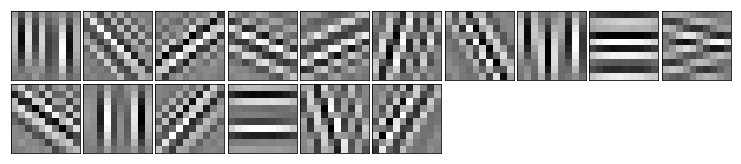

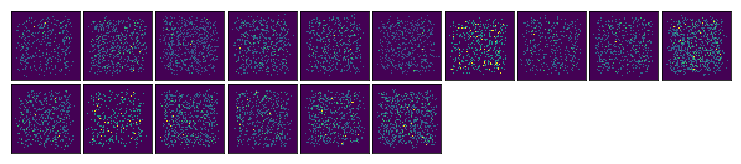

In [3]:
DisplayDico(L1.dictionary)
DisplayWhere(L1.where)

On binarise au seuil de 0.01 :

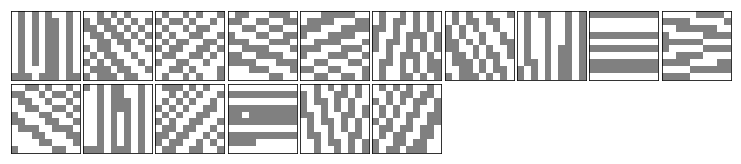

In [4]:
for a, x in enumerate(L1.dictionary) :
    for b, y in enumerate(x) : 
        for c, z in enumerate(y) :
            for d, h in enumerate(z):
                if h < 0.001 :
                    L1.dictionary[a][b][c][d] =0.0
                else :
                    L1.dictionary[a][b][c][d] = 1.0
        
DisplayDico(L1.dictionary)

Et on entraine pour le second layer, en reg logistique :

In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


class LogReg(nn.Module) :
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(10,4)
    
    def forward(self, x):
        out = self.linear(x)
        return out
    
model = LogReg()
print(model)

#CEL en SGD
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  

LogReg(
  (linear): Linear(in_features=10, out_features=4, bias=True)
)


On fit :

In [7]:
import torch
import torchvision
from torchvision import transforms, datasets

epochs = 50 
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1, drop_last = True)

for epoch in range(epochs ):
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        L1dico = Variable(L1.dictionary)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(L1dico)
        outputs = outputs.view(-1,40)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, epochs, i+1, len(train_set)//12, loss.data[0]))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/50], Step: [10/166], Loss: 3.6843
Epoch: [1/50], Step: [20/166], Loss: 3.7910
Epoch: [1/50], Step: [30/166], Loss: 4.1275
Epoch: [1/50], Step: [40/166], Loss: 3.7359
Epoch: [1/50], Step: [50/166], Loss: 3.6047
Epoch: [1/50], Step: [60/166], Loss: 3.8888
Epoch: [1/50], Step: [70/166], Loss: 3.9013
Epoch: [1/50], Step: [80/166], Loss: 3.8901
Epoch: [1/50], Step: [90/166], Loss: 3.8687
Epoch: [1/50], Step: [100/166], Loss: 3.8277
Epoch: [1/50], Step: [110/166], Loss: 3.8392
Epoch: [1/50], Step: [120/166], Loss: 3.8134
Epoch: [2/50], Step: [10/166], Loss: 3.9889
Epoch: [2/50], Step: [20/166], Loss: 3.9027
Epoch: [2/50], Step: [30/166], Loss: 3.6487
Epoch: [2/50], Step: [40/166], Loss: 3.8474
Epoch: [2/50], Step: [50/166], Loss: 3.7323
Epoch: [2/50], Step: [60/166], Loss: 3.6251
Epoch: [2/50], Step: [70/166], Loss: 3.8344
Epoch: [2/50], Step: [80/166], Loss: 3.6699
Epoch: [2/50], Step: [90/166], Loss: 3.7008
Epoch: [2/50], Step: [100/166], Loss: 3.8622
Epoch: [2/50], Step: [110/16

Epoch: [16/50], Step: [50/166], Loss: 3.6695
Epoch: [16/50], Step: [60/166], Loss: 3.7990
Epoch: [16/50], Step: [70/166], Loss: 3.6393
Epoch: [16/50], Step: [80/166], Loss: 3.7500
Epoch: [16/50], Step: [90/166], Loss: 3.7717
Epoch: [16/50], Step: [100/166], Loss: 3.6794
Epoch: [16/50], Step: [110/166], Loss: 3.6878
Epoch: [16/50], Step: [120/166], Loss: 3.6458
Epoch: [17/50], Step: [10/166], Loss: 3.7742
Epoch: [17/50], Step: [20/166], Loss: 3.7715
Epoch: [17/50], Step: [30/166], Loss: 3.6987
Epoch: [17/50], Step: [40/166], Loss: 3.7370
Epoch: [17/50], Step: [50/166], Loss: 3.7037
Epoch: [17/50], Step: [60/166], Loss: 3.6543
Epoch: [17/50], Step: [70/166], Loss: 3.7643
Epoch: [17/50], Step: [80/166], Loss: 3.7922
Epoch: [17/50], Step: [90/166], Loss: 3.6957
Epoch: [17/50], Step: [100/166], Loss: 3.7304
Epoch: [17/50], Step: [110/166], Loss: 3.6778
Epoch: [17/50], Step: [120/166], Loss: 3.8290
Epoch: [18/50], Step: [10/166], Loss: 3.7280
Epoch: [18/50], Step: [20/166], Loss: 3.8188
Epoc

Epoch: [31/50], Step: [70/166], Loss: 3.6720
Epoch: [31/50], Step: [80/166], Loss: 3.6744
Epoch: [31/50], Step: [90/166], Loss: 3.6991
Epoch: [31/50], Step: [100/166], Loss: 3.6609
Epoch: [31/50], Step: [110/166], Loss: 3.7157
Epoch: [31/50], Step: [120/166], Loss: 3.6933
Epoch: [32/50], Step: [10/166], Loss: 3.6823
Epoch: [32/50], Step: [20/166], Loss: 3.5871
Epoch: [32/50], Step: [30/166], Loss: 3.5824
Epoch: [32/50], Step: [40/166], Loss: 3.6774
Epoch: [32/50], Step: [50/166], Loss: 3.5833
Epoch: [32/50], Step: [60/166], Loss: 3.5910
Epoch: [32/50], Step: [70/166], Loss: 3.6009
Epoch: [32/50], Step: [80/166], Loss: 3.6765
Epoch: [32/50], Step: [90/166], Loss: 3.7032
Epoch: [32/50], Step: [100/166], Loss: 3.6619
Epoch: [32/50], Step: [110/166], Loss: 3.7353
Epoch: [32/50], Step: [120/166], Loss: 3.7142
Epoch: [33/50], Step: [10/166], Loss: 3.6042
Epoch: [33/50], Step: [20/166], Loss: 3.7376
Epoch: [33/50], Step: [30/166], Loss: 3.6302
Epoch: [33/50], Step: [40/166], Loss: 3.7281
Epoc

Epoch: [46/50], Step: [100/166], Loss: 3.6239
Epoch: [46/50], Step: [110/166], Loss: 3.7229
Epoch: [46/50], Step: [120/166], Loss: 3.5968
Epoch: [47/50], Step: [10/166], Loss: 3.6497
Epoch: [47/50], Step: [20/166], Loss: 3.6138
Epoch: [47/50], Step: [30/166], Loss: 3.5855
Epoch: [47/50], Step: [40/166], Loss: 3.6428
Epoch: [47/50], Step: [50/166], Loss: 3.5947
Epoch: [47/50], Step: [60/166], Loss: 3.6518
Epoch: [47/50], Step: [70/166], Loss: 3.5917
Epoch: [47/50], Step: [80/166], Loss: 3.5375
Epoch: [47/50], Step: [90/166], Loss: 3.6132
Epoch: [47/50], Step: [100/166], Loss: 3.6007
Epoch: [47/50], Step: [110/166], Loss: 3.6515
Epoch: [47/50], Step: [120/166], Loss: 3.6179
Epoch: [48/50], Step: [10/166], Loss: 3.5999
Epoch: [48/50], Step: [20/166], Loss: 3.5865
Epoch: [48/50], Step: [30/166], Loss: 3.5738
Epoch: [48/50], Step: [40/166], Loss: 3.6781
Epoch: [48/50], Step: [50/166], Loss: 3.5604
Epoch: [48/50], Step: [60/166], Loss: 3.6121
Epoch: [48/50], Step: [70/166], Loss: 3.5972
Epoc

On teste :

In [8]:
test_loss = 0
correct = 0

test_set = datasets.ImageFolder(root='clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=12,shuffle=False,
                                             num_workers=1,drop_last = True)

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 32 * 32)
    net_out = model(L1dico)
    net_out = net_out.view(-1,40)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


ValueError: Expected input batch_size (16) to match target batch_size (12).

Mais peut être que ça marche avec un réseau linéaire de ReLu comme pour le week1 ?

In [19]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
    
model = LogReg()
print(model)

#CEL en SGD
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  

import torch
import torchvision
from torchvision import transforms, datasets

epochs = 50 
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1, drop_last = True)

for epoch in range(epochs ):
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        L1dico = Variable(L1.dictionary)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(L1dico)
        outputs = outputs.view(-1,40)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, epochs, i+1, len(train_set)//12, loss.data[0]))

LogReg(
  (linear): Linear(in_features=10, out_features=4, bias=True)
)


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1/50], Step: [10/166], Loss: 3.9635
Epoch: [1/50], Step: [20/166], Loss: 3.8653
Epoch: [1/50], Step: [30/166], Loss: 3.8248
Epoch: [1/50], Step: [40/166], Loss: 3.7959
Epoch: [1/50], Step: [50/166], Loss: 3.8339
Epoch: [1/50], Step: [60/166], Loss: 3.7020
Epoch: [1/50], Step: [70/166], Loss: 3.8372
Epoch: [1/50], Step: [80/166], Loss: 3.6849
Epoch: [1/50], Step: [90/166], Loss: 3.7400
Epoch: [1/50], Step: [100/166], Loss: 3.6896
Epoch: [1/50], Step: [110/166], Loss: 3.9071
Epoch: [1/50], Step: [120/166], Loss: 3.7142
Epoch: [2/50], Step: [10/166], Loss: 3.6117


Traceback (most recent call last):
Process Process-14:
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Epoch: [2/50], Step: [20/166], Loss: 3.6818


KeyboardInterrupt: 

  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 130, in pil_loader
    return img.convert('

Et on teste encore une fois :

In [ ]:
test_loss = 0
correct = 0

test_set = datasets.ImageFolder(root='clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1,drop_last = True)

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 32 * 32)
    net_out = model(L1dico)
    net_out = net_out.view(-1,40)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))